In [1]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("drsaeedmohsen/ucihar-dataset") + '/UCI-HAR Dataset'
path = '/home/tibless/.cache/kagglehub/datasets/drsaeedmohsen/ucihar-dataset/versions/1/UCI-HAR Dataset'
print("Path to dataset files:", path)

Path to dataset files: /home/tibless/.cache/kagglehub/datasets/drsaeedmohsen/ucihar-dataset/versions/1/UCI-HAR Dataset


In [2]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import random, jit, tree, grad, lax

key = random.PRNGKey(273)

TRAIN_PATH = path + '/train/Inertial Signals/'
TEST_PATH = path + '/test/Inertial Signals/'
PREFIXS = [
    'body_acc_x_',
    'body_acc_y_',
    'body_acc_z_',
    'body_gyro_x_',
    'body_gyro_y_',
    'body_gyro_z_',
    'total_acc_x_',
    'total_acc_y_',
    'total_acc_z_',
]

X_train = []
for prefix in PREFIXS:
    X_train.append(pd.read_csv(TRAIN_PATH + prefix + 'train.txt', header=None, sep=r'\s+').to_numpy())

X_train = np.transpose(np.array(X_train), (1, 0, 2))
X_train = jnp.array(X_train)

X_test = []
for prefix in PREFIXS:
    X_test.append(pd.read_csv(TEST_PATH + prefix + 'test.txt', header=None, sep=r'\s+').to_numpy())
X_test = np.transpose(np.array(X_test), (1, 0, 2))
X_test = jnp.array(X_test)


y_train = jnp.array(pd.read_csv(path + '/train/y_train.txt', header=None).to_numpy().squeeze() - 1)
y_test = jnp.array(pd.read_csv(path + '/test/y_test.txt', header=None).to_numpy().squeeze() - 1)

# 将标签转换为 one-hot 编码
def one_hot(y: jnp.ndarray, num_class: int):
    res = jnp.zeros((y.shape[0], num_class))
    res = res.at[jnp.arange(y.shape[0]), y].set(1)
    return res

y_train = one_hot(y_train, 6)
y_test = one_hot(y_test, 6)

# Suffle
TRAIN = None
TEST = None

shuffle_kernel = random.permutation(key, (X_train.shape[0]))
X_train = X_train[shuffle_kernel][:TRAIN]
y_train = y_train[shuffle_kernel][:TRAIN]
shuffle_kernel = random.permutation(key, (X_test.shape[0]))
X_test = X_test[shuffle_kernel][:TEST]
y_test = y_test[shuffle_kernel][:TEST]

print('X_train 形状:', X_train.shape)  # 应为 (7352, 128, 9)
print('y_train 形状:', y_train.shape)  # 应为 (7352, 6)
print('X_test  形状:', X_test.shape)
print('y_test  形状:', y_test.shape)

X_train 形状: (7352, 9, 128)
y_train 形状: (7352, 6)
X_test  形状: (2947, 9, 128)
y_test  形状: (2947, 6)


In [3]:
import jax.numpy as jnp
from jax import jit, grad

from plugins.minitorch.initer import Initer
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.nn import Rnn, Dense
from plugins.minitorch.utils import softmax, cross_entropy_loss

class gru_clf:
    def __init__(self, lr=0.01, batch_size=32):
        
        self.config = {
            'gru:0': Rnn.get_gru(128, 9, 64),
            'fc:0': Dense.get_linear(64, 6),
        }

        initer = Initer(self.config, random.PRNGKey(42))
        self.optr = Adam(initer(), lr=lr, batch_size=batch_size)
  
    def predict_proba(self, x: jnp.ndarray, params, train=True):
        res = jnp.transpose(x, (2, 0, 1))
        res, _ = Rnn._gru_cell(res, 
                              jnp.zeros((res.shape[1], self.config['gru:0']['hidden_dim'])), 
                              params['gru:0']['Ws'], params['gru:0']['Us'], params['gru:0']['Bs'])

        res = res[-1]
        res = res @ params['fc:0']['w'] + params['fc:0']['b']

        return softmax(res)
        
    def fit(self, x_train, y_train_proba, x_test, y_test_proba, epoches=100): 
        @jit
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return jnp.mean(y_true == y_pred)

        _loss = lambda params, x, y_true: cross_entropy_loss(y_true, self.predict_proba(x, params, True)) 
        _loss = jit(_loss)  # accelerate loss function by JIT
        self.optr.open(_loss, x_train, y_train_proba)
        
        _tloss = lambda params, x, y_true: cross_entropy_loss(y_true, self.predict_proba(x, params, False)) 
        _tloss = jit(_tloss)  # accelerate loss function by JIT
        

        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss

        for cnt in range(epoches):
            loss.append(_loss(self.optr.get_params(), x_train, y_train_proba))
            tloss.append(_tloss(self.optr.get_params(), x_test, y_test_proba))

            self.optr.update()
            
            acc.append(_acc(y_train_proba, self.predict_proba(x_train, self.optr.get_params())))
            tacc.append(_acc(y_test_proba, self.predict_proba(x_test, self.optr.get_params())))
            if (cnt + 1) % 3 == 0:
                print(f'>> epoch: {cnt + 1}, train acc: {acc[-1]}, train loss: {loss[-1]}; test acc: {tacc[-1]}, test loss: {tloss[-1]}')

        return acc, loss, tacc, tloss

In [4]:
epochs = 30
batch_size = 64
lr = 0.005

model = gru_clf(lr=lr, batch_size=batch_size)
acc, loss, tacc, tloss = model.fit(
    x_train = X_train,
    y_train_proba = y_train,
    x_test = X_test,
    y_test_proba = y_test,
    epoches = epochs,
)

[*] oprimizer opened with 114 batches with batch size 64.
>> epoch: 3, train acc: 0.9534820318222046, train loss: 0.1621508002281189; test acc: 0.8975229263305664, test loss: 0.418098121881485
>> epoch: 6, train acc: 0.960010826587677, train loss: 0.11371050775051117; test acc: 0.9066847562789917, test loss: 0.24490606784820557
>> epoch: 9, train acc: 0.9601468443870544, train loss: 0.1079011857509613; test acc: 0.917203962802887, test loss: 0.2622726857662201
>> epoch: 12, train acc: 0.9526659250259399, train loss: 0.10616115480661392; test acc: 0.9158466458320618, test loss: 0.2928647994995117
>> epoch: 15, train acc: 0.9566104412078857, train loss: 0.10373437404632568; test acc: 0.9273837804794312, test loss: 0.20702201128005981
>> epoch: 18, train acc: 0.9589227437973022, train loss: 0.0944935753941536; test acc: 0.9270444512367249, test loss: 0.23009541630744934
>> epoch: 21, train acc: 0.9553862810134888, train loss: 0.09249404817819595; test acc: 0.9185612797737122, test loss: 0

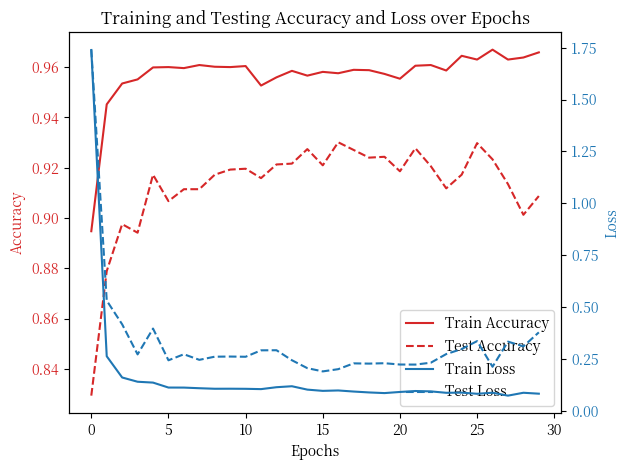

final train, test acc : 0.965859591960907, 0.9087207317352295
final train, test loss: 0.08416807651519775, 0.37937477231025696


In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
# plt.savefig('./assets/gru.png')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')